# Лабораторная работа #5. Классификация текста

__Выполнил__: Подцепко И.С., M3235.

In [1]:
import os
import numpy as np

message_names = sorted([f'./data/raw/{message_name}' for message_name in os.listdir('./data/raw')])


class Message:
    def __init__(self, subject: np.ndarray, body: np.ndarray, label: int):
        self.subject = subject
        self.body = body
        self.label = label


def parse_message(name) -> Message:
    label = 0 if 'legit' in name else 1
    with open(name) as file:
        content = file.readlines()
        subject = [int(word) for word in content[0].replace('Subject: ', '').split()]
        body = [int(word) for word in content[2].split()]
        return Message(np.array(subject).astype(int), np.array(body).astype(int), label)


messages = np.array([parse_message(name) for name in message_names])

# Чтобы не перемешивать в train_test_split; У всех должен быть одинаковый набор сообщений для проверки:
np.random.shuffle(messages)

labels = np.array([message.label for message in messages])

Так уж случилось, что я начал со второго пункта. Итак, подготовим две функции по-разному векторизующие текст.

1. `onehot_encode` -- для каждого слова создает признак: встретилось оно или нет;
2. `counter_encode` -- для каждого слова создает признак: сколько раз оно встретилось.

In [2]:
from scipy.sparse import csr_matrix
from collections import Counter


def onehot_encode(docs) -> csr_matrix:
    """ Создает разреженную матрицу, в ячейке (i, word) которой
    лежит 1, если слово word содержится в docs[i] """
    rows = []
    columns = []
    data = []
    for i in range(len(docs)):
        for word in set(docs[i]):
            rows.append(i)
            columns.append(word)
            data.append(1)
    return csr_matrix((data, (rows, columns)))


def counter_encode(docs) -> csr_matrix:
    """ Создает разреженную матрицу, в ячейке (i, word) которой
    лежит количество вхождений слова word в docs[i] """
    rows = []
    columns = []
    data = []
    for i in range(len(docs)):
        for word, count in Counter(docs[i]).items():
            rows.append(i)
            columns.append(word)
            data.append(count)
    return csr_matrix((data, (rows, columns)))

Следующий набор вспомогательных функций предоставляет инструменты для обучения модели, изображения ROC-кривой, подсчета AUC и кросс-валидации.

In [51]:
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
import matplotlib.pyplot as plt


def draw_roc(fpr, tpr, auc_score):
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.plot(fpr, tpr, label=f'ROC curve (area = {round(auc_score, 3)})')
    plt.legend(loc='lower right')
    plt.title("Receiver operating characteristic")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.show()


def get_scores(test, prediction):
    fpr, tpr, _ = roc_curve(test, prediction)
    auc_score = auc(fpr, tpr)
    return fpr, tpr, auc_score


def fit_naive_bayes(features, labels, class_prior=None) -> MultinomialNB:
    model = MultinomialNB(class_prior=None if class_prior is None else [1 - class_prior, class_prior])
    model.fit(features, labels)
    return model


def fit_and_get(features, labels):
    """ Обучает классификатор на предоставленных данных и рисует график с ROC-кривой """
    print(f'Features shape: {features.shape}')
    train_x, test_x, train_y, test_y = train_test_split(features, labels, test_size=0.2, shuffle=False)
    model = fit_naive_bayes(train_x, train_y)
    prediction = model.predict_proba(test_x)[:,1]
    draw_roc(*get_scores(test_y, prediction))


def check_with_cross_validation(features, labels, n_splits: int = 10, class_prior=None, use_auc: bool = True):
    k_fold = KFold(n_splits=n_splits, shuffle=False)
    total_score = 0
    for train, test in k_fold.split(features, labels):
        model = fit_naive_bayes(features[train], labels[train], class_prior)
        if use_auc:
            prediction = model.predict_proba(features[test])[:,1]
            fpr, tpr, auc_score = get_scores(labels[test], prediction)
            total_score += auc_score
        else: # use accuracy
            total_score += model.score(features[test], labels[test])
    return total_score / n_splits

Вернемся к первому пункту. В переменную `combined` поместим набор слов, который получается из склеивания заголовка и тела сообщения -- _первый способ учета заголовка и тела сообщения при векторизации_.

In [49]:
combined = [np.concatenate((message.subject, message.body)) for message in messages]

Features shape: (1090, 24748)


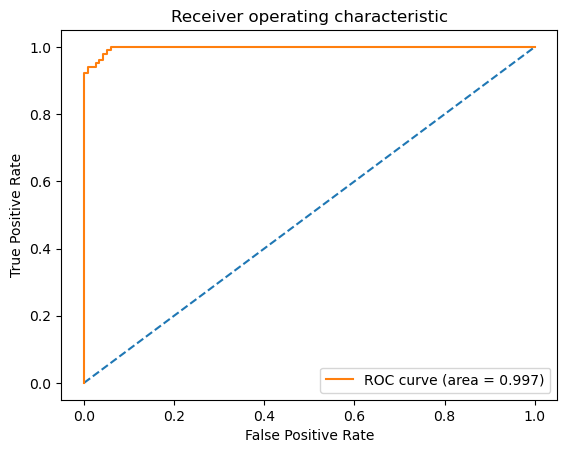

Total score: 0.9941134277629239


In [52]:
features = onehot_encode(combined)
fit_and_get(features, labels)
print(f'Total score: {check_with_cross_validation(features, labels)}')

Features shape: (1090, 24748)


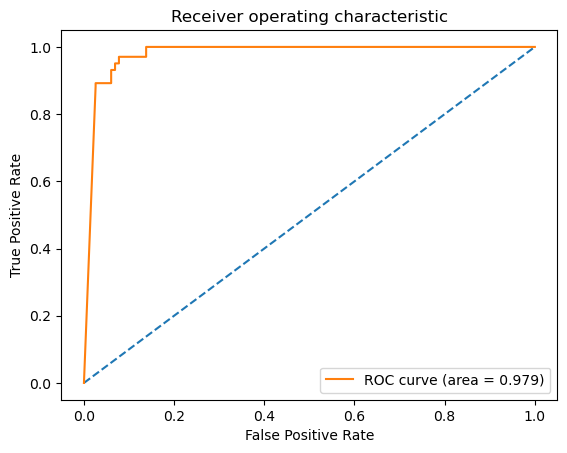

Total score: 0.9828041226824038


In [53]:
features = counter_encode(combined)
fit_and_get(features, labels)
print(f'Total score: {check_with_cross_validation(features, labels)}')

В переменную `separated` поместим набор слов, который содержит слова из заголовка и тела, но считает их разными -- _второй способ учета заголовка и тела сообщения при векторизации_.

Техническая деталь: слова из заголовка (или тела) необходимо перекодировать, но требуются целочисленные, неотрицательные коды для слов; Идея, которая пришла в голову (почему-то не сразу) - сместить коды слов из заголовка на значение максимального кода слов из тела. Таким образом, слова из тела займут диапазон 0...max, а слова из заголовка - max + 1...

In [55]:
shift = max([max(message.body) for message in messages])
separated = [
    np.concatenate(
        (message.subject + shift + 1, message.body)
    )
    for message in messages
]

Features shape: (1090, 49480)


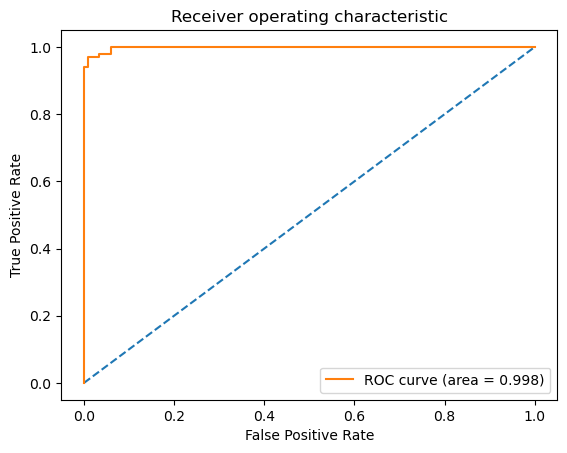

Total score: 0.9950016373987193


In [56]:
features = onehot_encode(separated)
fit_and_get(features, labels)
print(f'Total score: {check_with_cross_validation(features, labels)}')

Features shape: (1090, 49480)


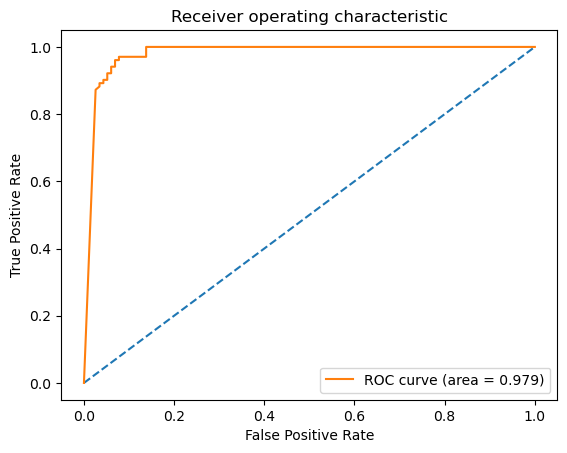

Total score: 0.9827021625226319


In [57]:
features = counter_encode(separated)
fit_and_get(features, labels)
print(f'Total score: {check_with_cross_validation(features, labels)}')

__Вывод__: Наилучшая комбинация из первых двух пунктов -- учитывать заголовок и тело раздельно и для каждого слова создавать признак: встретилось оно или нет.

In [58]:
from sklearn.metrics import confusion_matrix

features = onehot_encode(separated)
train_x, test_x, train_y, test_y = train_test_split(features, labels, test_size=0.2, shuffle=False)

epsilon = 1e-16
priori_spam_probability = 1 - epsilon
while True:
    model = fit_naive_bayes(train_x, train_y, priori_spam_probability)
    prediction = model.predict(test_x)
    false_positive = confusion_matrix(test_y, prediction)[0, 1]
    if false_positive == 0:
        break
    priori_spam_probability /= 2
print(f'FP = 0 when priori spam probability = {priori_spam_probability}')

FP = 0 when priori spam probability = 3.8146972656249996e-06


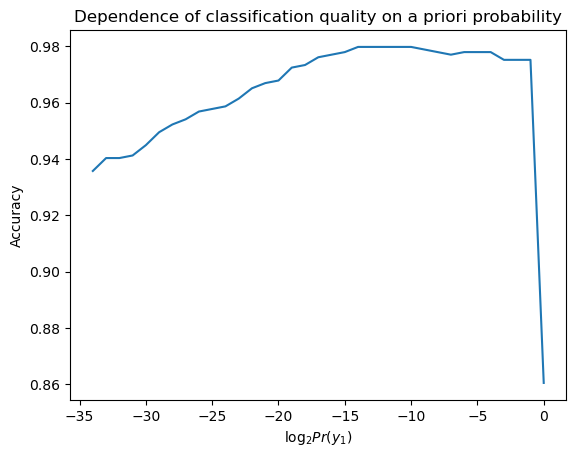

In [59]:
from math import log2

priori_probabilities = []
scores = []

features = onehot_encode(separated)
priori_spam_probability = 1 - epsilon

for i in range(35):
    priori_probabilities.append(log2(priori_spam_probability))
    scores.append(check_with_cross_validation(features, labels, class_prior=priori_spam_probability, use_auc=False))
    priori_spam_probability /= 2

plt.plot(priori_probabilities, scores)
plt.title("Dependence of classification quality on a priori probability")
plt.xlabel("$\log_2Pr(y_1)$")
plt.ylabel("Accuracy")
plt.show()